In [1]:

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset,Dataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [2]:

torch.manual_seed(13)
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class digits_datasets(Dataset):
    def __init__(self,x_tensor, y_tensor):
        super().__init__()
        self.X=x_tensor
        self.Y=y_tensor
        

    def __getitem__(self, index):
        return (self.X[index],self.Y[index])
    
    def __len__(self):
        return len(self.X)

In [4]:
class SimpleClassificationNet(torch.nn.Module):
            
    def __init__(self):
        super().__init__()        
        self.linearLayer1 = nn.Linear(64,32) #hidden layer 
        self.s1=nn.ReLU()
        self.linearLayer2 = nn.Linear(32,16)
        self.s2=nn.ReLU()
        self.linearLayer3 = nn.Linear(16,10)


    def forward(self,x):
        u=self.linearLayer1(x)
        v=self.s1(u)
        w=self.linearLayer2(v)
        x=self.s2(w)
        y_hat=self.linearLayer3(x)
        return y_hat

In [5]:
#Getting a toy dataset from scikit learn library
digits = load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y=digits.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)
#preprocessing normalizing the features (mean=0, var=1)
sc = StandardScaler()
sc.fit(X_train)  #note only from training data


StandardScaler()

<Figure size 432x288 with 0 Axes>

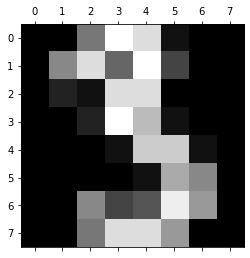

In [7]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[3])
plt.show()

In [8]:
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [10]:
#Preparing PyTorch DataSets and DataLoaders

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train).long()
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val).long()
# Builds dataset containing ALL data points
train_dataset = digits_datasets(x_train_tensor, y_train_tensor)
val_dataset = digits_datasets(x_val_tensor, y_val_tensor)
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

In [11]:
#model, optimizer and loss
model = SimpleClassificationNet().to(device)
stateDict=model.state_dict()
# print(stateDict)
# print(model)
# summary(model,(1,2))

lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss ()


In [12]:
#batch wise training loop
epochs = 100
train_losses = []
val_losses = []
best_accuracy=0
for epoch in range(epochs):  #epochs loop

    all_Y_train_epoch=np.array([]).reshape(0,1)
    all_Yhat_train_epoch=np.array([]).reshape(0,1)
    all_train_losses_epoch=np.array([])

    for X_train, Y_train in train_loader:        #batch wise  training on train set
        model.train()
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)  
        logits = model(X_train)               
        
        loss = loss_fn(logits, Y_train)       
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #store metrics for all batches of current epoch 
        y_hat=F.softmax(logits,dim=-1)
        y_hat=y_hat.detach().cpu().numpy()
        y_hat=np.argmax(y_hat,axis=1)
        y_hat=y_hat.reshape(-1,1)

        Y_train=Y_train.detach().cpu().numpy()
        Y_train=Y_train.reshape(-1,1)
        all_Y_train_epoch=np.vstack((all_Y_train_epoch,Y_train))
        all_Yhat_train_epoch=np.vstack((all_Yhat_train_epoch,y_hat))   
        all_train_losses_epoch=np.append(all_train_losses_epoch,loss.item())     
        
    
    
    #computing metrics for current epoch
    train_losses.append(all_train_losses_epoch.mean()) #mean loss for all batches    
    acTrain=accuracy_score(all_Y_train_epoch, all_Yhat_train_epoch)
    # print("all_Y_train_epoch",all_Y_train_epoch)
    # print("all_Yhat_train_epoch",all_Yhat_train_epoch)
    cmTrain=confusion_matrix(all_Y_train_epoch, all_Yhat_train_epoch)
    print(cmTrain)

    #validation loop also bacth wise
    all_Y_val_epoch=np.array([]).reshape(0,1)
    all_Yhat_val_epoch=np.array([]).reshape(0,1)
    all_val_losses_epoch=np.array([])
    
    for X_val, Y_val in val_loader:  #batch wise validation set predictions only
        model.eval()
        
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        
        with torch.no_grad():            
            logits = model(X_val)           
            loss = loss_fn(logits, Y_val)
        
        #store metrics for all batches of current epoch 
        y_hat_val=F.softmax(logits,dim=-1)
        y_hat_val=y_hat_val.detach().cpu().numpy()
        y_hat_val=np.argmax(y_hat_val,axis=1)
        y_hat_val=y_hat_val.reshape(-1,1)
        Y_val=Y_val.detach().cpu().numpy()
        Y_val=Y_val.reshape(-1,1)
        all_Y_val_epoch=np.vstack((all_Y_val_epoch,Y_val))
        all_Yhat_val_epoch=np.vstack((all_Yhat_val_epoch,y_hat_val))   
        all_val_losses_epoch=np.append(all_val_losses_epoch,loss.item())     
            

    #computing metrics for current epoch
    val_losses.append(all_val_losses_epoch.mean()) #mean loss for all batches    
    acVal=accuracy_score(all_Y_val_epoch, all_Yhat_val_epoch)
    # print("all_Y_val_epoch",all_Y_val_epoch)
    # print("all_Yhat_val_epoch",all_Yhat_val_epoch)
    cmVal=confusion_matrix(all_Y_val_epoch, all_Yhat_val_epoch)
    
    print(f"epoch= {epoch}, accuracyTrain= {acTrain}, accuracyVal= {acVal}, train_loss= {train_losses[epoch]}, validation_loss= {val_losses[epoch]}")

    #checkpointing training
    if(acVal>best_accuracy):
        checkpoint = {'epoch': epoch,'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),'loss': train_losses,
                      'val_loss': val_losses}
        torch.save(checkpoint,'best.pth')



#loading best model
checkpoint = torch.load('best.pth')
# Restore state for model and optimizer
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
total_epochs = checkpoint['epoch']
losses = checkpoint['loss']
val_losses = checkpoint['val_loss']

[[  0   0 133   0   0   0  13   2   0   0]
 [ 14   6  80   9   0   0   2  34   0   0]
 [  0  14 111   2   0   0   0  12   0   0]
 [  0  49  83   5   0   0   0   9   0   0]
 [  0   0 109   5   0   0   1  28   0   0]
 [  0  47  69  10   0   0   0  11   0   0]
 [  0   1  26  43   1   0  22  46   0   0]
 [  1   1 138   6   0   0   1   6   0   0]
 [  1  15  76  17   0   0   3  28   0   0]
 [  1  47  72  23   0   0   2   2   0   0]]
epoch= 0, accuracyTrain= 0.10438413361169102, accuracyVal= 0.11944444444444445, train_loss= 2.3090477188428244, validation_loss= 2.308881011274126
[[  0   0 130   1   0   0  15   2   0   0]
 [ 16   6  73   9   0   0   2  39   0   0]
 [  0  14 111   2   0   0   0  12   0   0]
 [  0  48  79   6   0   0   0  13   0   0]
 [  0   0 101   5   0   0   3  34   0   0]
 [  0  52  63   9   0   0   0  13   0   0]
 [  0   0  21  39   2   0  35  42   0   0]
 [  1   0 134   6   0   0   1  11   0   0]
 [  1  18  73  15   0   0   3  30   0   0]
 [  1  51  65  25   0   0   2   3  